# Задание 1

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neural_network import BernoulliRBM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

SEQ_LEN   = 256
N_SAMPLES = 500
N_HIDDEN  = 512
N_EPOCHS  = 200
LR        = 0.01

In [28]:
def generate_sine_dataset(n_samples: int, seq_len: int) -> np.ndarray:
    """Генерирует матрицу n_samples × seq_len синусоид с случайной фазой."""
    x = np.linspace(0, 2 * np.pi, seq_len)
    phases = np.random.uniform(0, 2 * np.pi, size=n_samples)
    data = np.array([np.sin(x + p) for p in phases])
    data = (data - data.min()) / (data.max() - data.min())
    return data

Reconstruction MSE: 0.12856


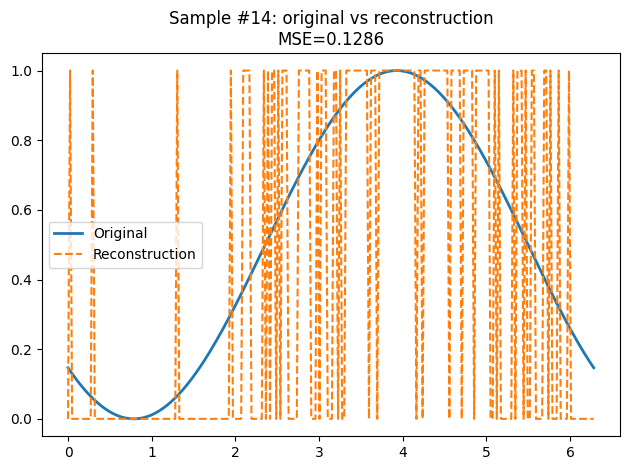

In [29]:
X = generate_sine_dataset(N_SAMPLES, SEQ_LEN)

rbm = BernoulliRBM(n_components=N_HIDDEN,
                   learning_rate=LR,
                   batch_size=10,
                   n_iter=N_EPOCHS,
                   random_state=2005)
rbm.fit(X)

# одноступенчатая реконструкция
X_hat = rbm.gibbs(X)
mse = mean_squared_error(X, X_hat)
print(f"Reconstruction MSE: {mse:.5f}")

# рисуем один случайный пример
idx = np.random.randint(0, N_SAMPLES)
t = np.linspace(0, 2 * np.pi, SEQ_LEN)
plt.plot(t, X[idx], label="Original", linewidth=2)
plt.plot(t, X_hat[idx], "--", label="Reconstruction")
plt.legend()
plt.title(f"Sample #{idx}: original vs reconstruction\nMSE={mse:.4f}")
plt.tight_layout()
plt.show()

# Задание 2

In [30]:
movies = (pd.read_csv(
              "datasets/movies_metadata.csv",
              usecols=["id", "title"],
              dtype={"id":  "string"},
          )
          .assign(id=lambda df: pd.to_numeric(df.id, errors="coerce"))
          .dropna(subset=["id"])
          .astype({"id": "int32"}))             # компактнее, быстрее

ratings = (pd.read_csv(
               "datasets/ratings.csv",
               usecols=["userId", "movieId", "rating"],
               dtype={"userId":"int32", "movieId":"int32", "rating":"float32"})
           .query("userId <= 10_000"))

In [31]:
popular_movie_ids = (
    ratings.groupby("movieId", observed=True)
           .size()
           .loc[lambda s: s > 100]
           .index
)

ratings_popular = ratings[ratings.movieId.isin(popular_movie_ids)]

df_ready = (ratings_popular
            .merge(movies, left_on="movieId", right_on="id", how="inner")
            .groupby(["userId", "title"], as_index=False, observed=True)
            .rating.mean()
)

In [32]:
print(df_ready.head())

   userId                                 title  rating
0       1                       Caesar Must Die     5.0
1       1  Confession of a Child of the Century     4.0
2       1                         Fools Rush In     4.0
3       1                        License to Wed     4.0
4       1                          Rocky Balboa     5.0


In [33]:
rating_matrix = df_ready.pivot(index='userId', columns='title', values='rating')
rating_matrix.fillna(0, inplace=True)

X = rating_matrix.values

In [34]:
rng = np.random.default_rng(2005)
mask = (X > 0)
train_mask = mask & (rng.random(mask.shape) > 0.2)
test_mask  = mask & ~train_mask

X_train = X.copy()
X_train[test_mask] = 0

In [35]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [36]:
rbm = BernoulliRBM(n_components=N_HIDDEN, learning_rate=LR, batch_size=10, n_iter=50, random_state=2005)
rbm.fit(X_train_scaled)

BernoulliRBM(learning_rate=0.01, n_components=512, n_iter=50, random_state=2005)

In [37]:
X_hidden   = rbm.transform(X_train_scaled)
X_recon    = np.dot(X_hidden, rbm.components_) + rbm.intercept_visible_
X_pred     = scaler.inverse_transform(X_recon)

In [38]:
y_true = X[test_mask]
y_pred = X_pred[test_mask]

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae  = mean_absolute_error(y_true, y_pred)
print(f"RMSE: {rmse:.4f} | MAE: {mae:.4f}")

RMSE: 15.6497 | MAE: 13.2427


In [39]:
def precision_recall_at_k(X_true, X_pred, mask, k=5, threshold=3.5):
    precisions, recalls = [], []

    for user_idx in range(X_true.shape[0]):
        relevant_mask = (mask[user_idx] & (X_true[user_idx] >= threshold))
        if not relevant_mask.any():
            continue

        candidate_idx = np.where(mask[user_idx])[0]
        top_k_idx = candidate_idx[np.argsort(X_pred[user_idx, candidate_idx])[::-1][:k]]

        tp = np.intersect1d(top_k_idx, np.where(relevant_mask)[0]).size
        precisions.append(tp / k)
        recalls.append(tp / relevant_mask.sum())

    return np.mean(precisions), np.mean(recalls)

In [40]:
prec, rec = precision_recall_at_k(X, X_pred, test_mask, k=5, threshold=3.5)
print(f"Precision: {prec:.3f} | Recall: {rec:.3f}")

Precision: 0.557 | Recall: 0.760


In [41]:
def recommend_movies(user_index, original_matrix, predicted_matrix, movie_titles, threshold=3.5, top_n=5):
    unrated = original_matrix[user_index] == 0
    predictions = predicted_matrix[user_index][unrated]
    movie_names = movie_titles[unrated]

    high_score_indices = np.where(predictions >= threshold)[0]
    if len(high_score_indices) == 0:
        return []

    sorted_indices = high_score_indices[np.argsort(predictions[high_score_indices])[::-1]]
    recommendations = list(zip(movie_names[sorted_indices], predictions[sorted_indices]))
    return recommendations[:top_n]

In [54]:
user_id = 993
movie_titles = rating_matrix.columns.to_numpy()
recommendations = recommend_movies(user_id, X, X_pred, movie_titles, threshold=3.0)
if recommendations:
    print(f"🎉 Рекомендации для пользователя {user_id+1} с предсказанным рейтингом > 3.0:")
    for title, score in recommendations:
        print(f"  {title} — {score:.2f}")
else:
    print("❗ Нет фильмов с предсказанным рейтингом выше 3.0 для этого пользователя.")

🎉 Рекомендации для пользователя 994 с предсказанным рейтингом > 3.0:
  The Cave of the Yellow Dog — 5.49
  Young and Innocent — 4.25
